In [ ]:
# ================================================================
# SNAPSHELF - CUSTOM CNN MODEL TRAINING
# ================================================================
# Project:      SnapShelf - Smart Food Inventory Management
# Module:       MOD002691 - Final Project (BSc Software Engineering)
# Institution:  Anglia Ruskin University, Cambridge
# Author:       Oriol Morros Vilaseca (SID: 2270056)
# Supervisor:   Mr Vitaliy Milke
# Date:         January 2026
# ================================================================
#
# PURPOSE:
# This notebook trains a custom Convolutional Neural Network (CNN)
# from scratch for food image classification. The model architecture
# consists of 3 convolutional blocks followed by fully connected layers.
#
# This is Model 1 of 3 in the comparison study:
#   1. Custom CNN (this notebook)
#   2. EfficientNetB0 (transfer learning)
#   3. ResNet-50 (transfer learning)
#
# RESEARCH QUESTION:
# How do different image classification approaches compare in
# accuracy, inference time, and computational efficiency for
# household food item recognition?
#
# INPUT:
#   - snapshelf_dataset_14classes_70-15-15.zip (from Notebook 01)
#
# OUTPUT:
#   - Trained model: snapshelf_custom_cnn.keras
#   - Training history and metrics
#   - Evaluation results on test set
#
# ================================================================

import sys
import platform
from datetime import datetime

print("=" * 65)
print("SNAPSHELF AI - CUSTOM CNN TRAINING")
print("=" * 65)
print(f"Execution Date:  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python Version:  {sys.version.split()[0]}")
print(f"Platform:        {platform.platform()}")
print("=" * 65)

SNAPSHELF AI - CUSTOM CNN TRAINING
Execution Date:  2026-01-03 20:32:33
Python Version:  3.12.12
Platform:        Linux-6.6.105+-x86_64-with-glibc2.35


In [6]:
# ================================================================
# CELL 2: IMPORT LIBRARIES & CHECK GPU
# ================================================================
# TensorFlow/Keras for model building and training.
# GPU acceleration significantly reduces training time.
# ================================================================

import os
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# CHECK GPU AVAILABILITY
# -----------------------------
print("=" * 65)
print("ENVIRONMENT CHECK")
print("=" * 65)

print(f"\nTensorFlow Version: {tf.__version__}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Available:      Yes")
    print(f"GPU Device:         {gpus[0].name}")
    # Enable memory growth to avoid OOM errors
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print(f"GPU Available:      No")


print(f"Random Seed:        {SEED}")
print(f"\nLibraries imported successfully.")

ENVIRONMENT CHECK

TensorFlow Version: 2.19.0
GPU Available:      Yes
GPU Device:         /physical_device:GPU:0
Random Seed:        42

Libraries imported successfully.


In [7]:
# ================================================================
# CELL 3: MOUNT GOOGLE DRIVE & LOAD DATASET
# ================================================================
# Loads the prepared dataset from Notebook 01.
# Extracts to local storage for faster training.
# ================================================================

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# -----------------------------
# CONFIGURATION
# -----------------------------
DATASET_ZIP = "/content/drive/MyDrive/snapshelf_datasets/snapshelf_dataset_14classes_70-15-15.zip"
LOCAL_DATASET = "/content/snapshelf_dataset"

print("=" * 65)
print("LOADING DATASET")
print("=" * 65)

# Verify zip file exists
if not os.path.exists(DATASET_ZIP):
    raise FileNotFoundError(f"Dataset not found: {DATASET_ZIP}")

zip_size_mb = os.path.getsize(DATASET_ZIP) / (1024 * 1024)
print(f"\nDataset archive: {DATASET_ZIP}")
print(f"Archive size:    {zip_size_mb:.1f} MB")

# -----------------------------
# EXTRACT DATASET
# -----------------------------
print(f"\nExtracting to: {LOCAL_DATASET}")

# Clean extraction directory
if os.path.exists(LOCAL_DATASET):
    shutil.rmtree(LOCAL_DATASET)

# Extract
with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
    zip_ref.extractall(LOCAL_DATASET)

print("Extraction complete.")

# -----------------------------
# VERIFY STRUCTURE
# -----------------------------
TRAIN_DIR = f"{LOCAL_DATASET}/train"
VAL_DIR = f"{LOCAL_DATASET}/val"
TEST_DIR = f"{LOCAL_DATASET}/test"

print(f"\nDataset structure:")
for split_name, split_dir in [("Train", TRAIN_DIR), ("Val", VAL_DIR), ("Test", TEST_DIR)]:
    if os.path.exists(split_dir):
        n_classes = len(os.listdir(split_dir))
        n_images = sum(len(files) for _, _, files in os.walk(split_dir))
        print(f"  {split_name + ':':<8} {n_classes} classes, {n_images:,} images")
    else:
        print(f"  {split_name}: NOT FOUND")

# Get class names
CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))
NUM_CLASSES = len(CLASS_NAMES)

print(f"\nClasses ({NUM_CLASSES}): {', '.join(CLASS_NAMES)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LOADING DATASET

Dataset archive: /content/drive/MyDrive/snapshelf_datasets/snapshelf_dataset_14classes_70-15-15.zip
Archive size:    2445.3 MB

Extracting to: /content/snapshelf_dataset
Extraction complete.

Dataset structure:
  Train:   14 classes, 117,151 images
  Val:     14 classes, 25,099 images
  Test:    14 classes, 25,116 images

Classes (14): apple, banana, bell_pepper_green, bell_pepper_red, carrot, cucumber, grape, lemon, onion, orange, peach, potato, strawberry, tomato


In [9]:
# ================================================================
# CELL 4: CONFIGURE DATA GENERATORS
# ================================================================
# Creates ImageDataGenerator objects for loading and augmenting images.
# Training data uses augmentation to improve generalization.
# Validation and test data use only rescaling (no augmentation).
# ================================================================

# -----------------------------
# HYPERPARAMETERS
# -----------------------------
IMG_SIZE = (100, 100)  # Same as original Fruits-360 dataset
BATCH_SIZE = 32        # Suitable for Colab free tier GPU
COLOR_MODE = 'rgb'

print("=" * 65)
print("DATA GENERATOR CONFIGURATION")
print("=" * 65)

print(f"\nImage size:    {IMG_SIZE[0]}x{IMG_SIZE[1]} pixels")
print(f"Batch size:    {BATCH_SIZE}")
print(f"Color mode:    {COLOR_MODE}")

# -----------------------------
# TRAINING DATA GENERATOR
# -----------------------------
# Augmentation helps prevent overfitting and improves generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0,1]
    rotation_range=20,        # Random rotation up to 20 degrees
    width_shift_range=0.1,    # Random horizontal shift
    height_shift_range=0.1,   # Random vertical shift
    shear_range=0.1,          # Random shear transformation
    zoom_range=0.1,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    fill_mode='nearest'       # Fill strategy for new pixels
)

# -----------------------------
# VALIDATION & TEST DATA GENERATOR
# -----------------------------
# No augmentation - only rescaling for consistent evaluation
val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

# -----------------------------
# CREATE GENERATORS
# -----------------------------
print("\nCreating data generators...")

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# VERIFY GENERATORS
# -----------------------------
print(f"\nGenerator Summary:")
print(f"  Training:   {train_generator.samples:,} images, {train_generator.num_classes} classes")
print(f"  Validation: {val_generator.samples:,} images, {val_generator.num_classes} classes")
print(f"  Test:       {test_generator.samples:,} images, {test_generator.num_classes} classes")

# Store class indices for later use
CLASS_INDICES = train_generator.class_indices
INDEX_TO_CLASS = {v: k for k, v in CLASS_INDICES.items()}

print(f"\nClass mapping: {CLASS_INDICES}")

DATA GENERATOR CONFIGURATION

Image size:    100x100 pixels
Batch size:    32
Color mode:    rgb

Creating data generators...
Found 117151 images belonging to 14 classes.
Found 25099 images belonging to 14 classes.
Found 25116 images belonging to 14 classes.

Generator Summary:
  Training:   117,151 images, 14 classes
  Validation: 25,099 images, 14 classes
  Test:       25,116 images, 14 classes

Class mapping: {'apple': 0, 'banana': 1, 'bell_pepper_green': 2, 'bell_pepper_red': 3, 'carrot': 4, 'cucumber': 5, 'grape': 6, 'lemon': 7, 'onion': 8, 'orange': 9, 'peach': 10, 'potato': 11, 'strawberry': 12, 'tomato': 13}


In [10]:
# ================================================================
# CELL 5: BUILD CUSTOM CNN ARCHITECTURE
# ================================================================
# A custom CNN built from scratch with 3 convolutional blocks.
# Architecture:
#   - Conv Block 1: 32 filters, 3x3 kernel, MaxPool
#   - Conv Block 2: 64 filters, 3x3 kernel, MaxPool
#   - Conv Block 3: 128 filters, 3x3 kernel, MaxPool
#   - Flatten + Dense (256 units) + Dropout
#   - Output: 14 classes (softmax)
#
# This architecture is intentionally simple to serve as a baseline
# for comparison against transfer learning and YOLO approaches.
# ================================================================

print("=" * 65)
print("BUILDING CUSTOM CNN MODEL")
print("=" * 65)

# -----------------------------
# MODEL ARCHITECTURE
# -----------------------------
model = models.Sequential([
    # Input layer
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'),
    layers.BatchNormalization(name='bn1'),
    layers.MaxPooling2D((2, 2), name='pool1'),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
    layers.BatchNormalization(name='bn2'),
    layers.MaxPooling2D((2, 2), name='pool2'),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
    layers.BatchNormalization(name='bn3'),
    layers.MaxPooling2D((2, 2), name='pool3'),

    # Flatten and Dense layers
    layers.Flatten(name='flatten'),
    layers.Dense(256, activation='relu', name='dense1'),
    layers.Dropout(0.5, name='dropout'),

    # Output layer
    layers.Dense(NUM_CLASSES, activation='softmax', name='output')
], name='SnapShelf_Custom_CNN')

# -----------------------------
# COMPILE MODEL
# -----------------------------
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# MODEL SUMMARY
# -----------------------------
print("\nModel Architecture:")
print("-" * 65)
model.summary()

# Calculate model size
total_params = model.count_params()
model_size_mb = total_params * 4 / (1024 * 1024)  # Assuming float32

print("-" * 65)
print(f"\nTotal Parameters:     {total_params:,}")
print(f"Estimated Model Size: {model_size_mb:.2f} MB")

BUILDING CUSTOM CNN MODEL

Model Architecture:
-----------------------------------------------------------------


Model: "SnapShelf_Custom_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 100, 100, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 50, 50, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 25, 25, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,816,590 (18.37 MB)

 Trainable params: 4,816,142 (18.37 MB)

 Non-trainable params: 448 (1.75 KB)

-----------------------------------------------------------------

Total Parameters:     4,816,590
Estimated Model Size: 18.37 MB


In [11]:
# ================================================================
# CELL 6: CONFIGURE TRAINING CALLBACKS
# ================================================================
# Callbacks monitor training and help prevent overfitting:
#   - EarlyStopping: Stops training when validation loss stops improving
#   - ModelCheckpoint: Saves the best model based on validation accuracy
#   - ReduceLROnPlateau: Reduces learning rate when progress stalls
# ================================================================

print("=" * 65)
print("TRAINING CALLBACKS CONFIGURATION")
print("=" * 65)

# Directory for saving model checkpoints
CHECKPOINT_DIR = "/content/model_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

BEST_MODEL_PATH = f"{CHECKPOINT_DIR}/best_custom_cnn.keras"

# -----------------------------
# CALLBACKS
# -----------------------------
callback_list = [
    # Stop training when validation loss stops improving
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),

    # Save the best model based on validation accuracy
    callbacks.ModelCheckpoint(
        filepath=BEST_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

print("\nCallbacks configured:")
print(f"  - EarlyStopping:      patience=5, monitor='val_loss'")
print(f"  - ModelCheckpoint:    save best to '{BEST_MODEL_PATH}'")
print(f"  - ReduceLROnPlateau:  factor=0.5, patience=3")

# -----------------------------
# TRAINING PARAMETERS
# -----------------------------
EPOCHS = 30  # Maximum epochs (early stopping will likely trigger before)

# Calculate steps per epoch
STEPS_PER_EPOCH = train_generator.samples // BATCH_SIZE
VALIDATION_STEPS = val_generator.samples // BATCH_SIZE

print(f"\nTraining parameters:")
print(f"  - Max epochs:        {EPOCHS}")
print(f"  - Steps per epoch:   {STEPS_PER_EPOCH:,}")
print(f"  - Validation steps:  {VALIDATION_STEPS:,}")
print(f"  - Batch size:        {BATCH_SIZE}")

TRAINING CALLBACKS CONFIGURATION

Callbacks configured:
  - EarlyStopping:      patience=5, monitor='val_loss'
  - ModelCheckpoint:    save best to '/content/model_checkpoints/best_custom_cnn.keras'
  - ReduceLROnPlateau:  factor=0.5, patience=3

Training parameters:
  - Max epochs:        30
  - Steps per epoch:   3,660
  - Validation steps:  784
  - Batch size:        32


In [12]:
# ================================================================
# CELL 7: TRAIN THE MODEL
# ================================================================
# Trains the CNN on the training set with validation monitoring.
# This will take approximately 20-40 minutes on Colab free tier GPU.
# ================================================================

print("=" * 65)
print("TRAINING CUSTOM CNN")
print("=" * 65)

print(f"\nStarting training at: {datetime.now().strftime('%H:%M:%S')}")
print(f"Training on {train_generator.samples:,} images")
print(f"Validating on {val_generator.samples:,} images")
print("-" * 65)

# Record start time
training_start = datetime.now()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=callback_list,
    verbose=1
)

# Record end time
training_end = datetime.now()
training_duration = training_end - training_start

print("-" * 65)
print(f"Training completed at: {training_end.strftime('%H:%M:%S')}")
print(f"Total training time:   {training_duration}")
print(f"Epochs completed:      {len(history.history['loss'])}")

# Store training duration for later reporting
TRAINING_TIME_SECONDS = training_duration.total_seconds()

TRAINING CUSTOM CNN

Starting training at: 18:16:13
Training on 117,151 images
Validating on 25,099 images
-----------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6312 - loss: 1.3659
Epoch 1: val_accuracy improved from -inf to 0.90749, saving model to /content/model_checkpoints/best_custom_cnn.keras
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 461s 124ms/step - accuracy: 0.6312 - loss: 1.3658 - val_accuracy: 0.9075 - val_loss: 0.3275 - learning_rate: 0.0010
Epoch 2/30
   1/3660 ━━━━━━━━━━━━━━━━━━━━ 1:21 22ms/step - accuracy: 0.9375 - loss: 0.2123

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.90749 to 0.91044, saving model to /content/model_checkpoints/best_custom_cnn.keras
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9375 - loss: 0.2123 - val_accuracy: 0.9104 - val_loss: 0.3172 - learning_rate: 0.0010
Epoch 3/30
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8706 - loss: 0.3889
Epoch 3: val_accuracy improved from 0.91044 to 0.96221, saving model to /content/model_checkpoints/best_custom_cnn.keras
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 431s 118ms/step - accuracy: 0.8706 - loss: 0.3889 - val_accuracy: 0.9622 - val_loss: 0.1072 - learning_rate: 0.0010
Epoch 4/30
   1/3660 ━━━━━━━━━━━━━━━━━━━━ 1:26 24ms/step - accuracy: 0.9375 - loss: 0.0977
Epoch 4: val_accuracy improved from 0.96221 to 0.96421, saving model to /content/model_checkpoints/best_custom_cnn.keras
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9375 - loss: 0.0977 - val_accuracy: 0.9642 - val_loss: 0.1012 - learning_rate: 0.0010
Epoch 5/30
3660/3660

TRAINING HISTORY


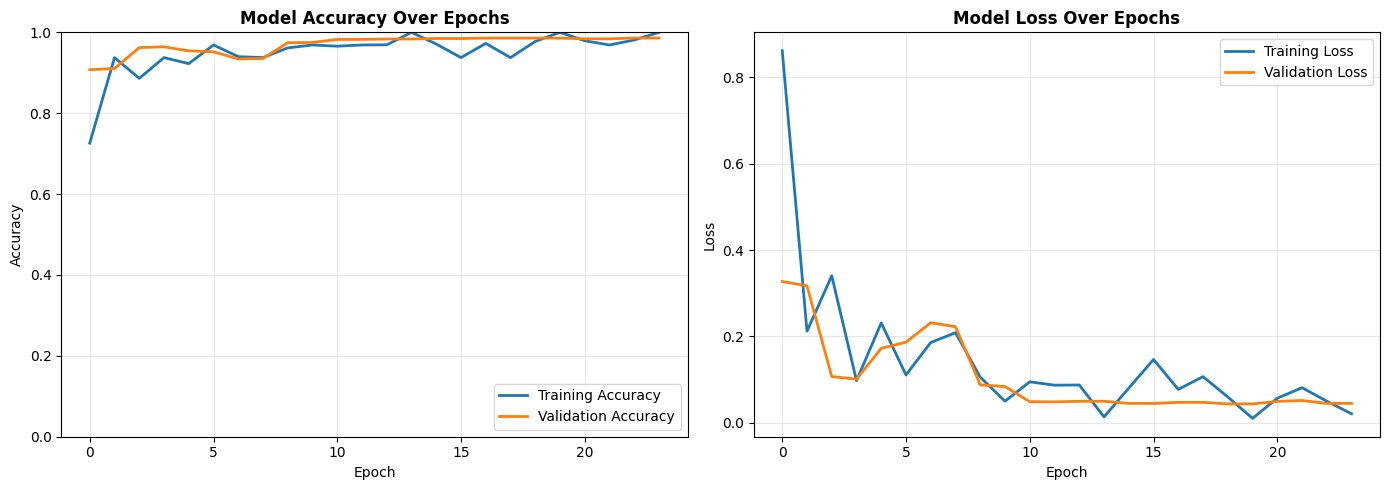


Plot saved to: /content/custom_cnn_training_history.png

Training Summary:
  Total epochs:         24
  Best epoch:           23
  Best val accuracy:    0.9860 (98.60%)
  Best val loss:        0.0451
  Training time:        1:29:15.221800


In [13]:
# ================================================================
# CELL 8: PLOT TRAINING HISTORY
# ================================================================
# Visualizes training and validation accuracy/loss over epochs.
# These plots will be included in your dissertation.
# ================================================================

print("=" * 65)
print("TRAINING HISTORY")
print("=" * 65)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -----------------------------
# ACCURACY PLOT
# -----------------------------
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# -----------------------------
# LOSS PLOT
# -----------------------------
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/custom_cnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to: /content/custom_cnn_training_history.png")

# -----------------------------
# TRAINING SUMMARY
# -----------------------------
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = max(history.history['val_accuracy'])
best_val_loss = history.history['val_loss'][best_epoch - 1]

print(f"\nTraining Summary:")
print(f"  Total epochs:         {len(history.history['loss'])}")
print(f"  Best epoch:           {best_epoch}")
print(f"  Best val accuracy:    {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  Best val loss:        {best_val_loss:.4f}")
print(f"  Training time:        {training_duration}")

In [14]:
# ================================================================
# CELL 9: EVALUATE ON TEST SET
# ================================================================
# Final evaluation on the held-out test set.
# This is the number that matters for your dissertation comparison.
# ================================================================

print("=" * 65)
print("TEST SET EVALUATION")
print("=" * 65)

# Load the best model
print("\nLoading best model from checkpoint...")
best_model = keras.models.load_model(BEST_MODEL_PATH)

# Reset test generator
test_generator.reset()

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_accuracy = best_model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

print(f"\n{'=' * 40}")
print(f"TEST RESULTS")
print(f"{'=' * 40}")
print(f"Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss:      {test_loss:.4f}")

TEST SET EVALUATION

Loading best model from checkpoint...
Evaluating on test set...
785/785 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.9831 - loss: 0.0503

TEST RESULTS
Test Accuracy:  0.9850 (98.50%)
Test Loss:      0.0457


DETAILED CLASSIFICATION METRICS

Generating predictions on test set...
785/785 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step

CLASSIFICATION REPORT
                   precision    recall  f1-score   support

            apple     0.9894    0.9843    0.9869     10409
           banana     0.8903    0.9100    0.9001       856
bell_pepper_green     1.0000    1.0000    1.0000       156
  bell_pepper_red     1.0000    1.0000    1.0000       234
           carrot     1.0000    1.0000    1.0000        61
         cucumber     0.9996    1.0000    0.9998      2367
            grape     0.9548    0.9218    0.9380      1330
            lemon     1.0000    1.0000    1.0000       272
            onion     0.9972    1.0000    0.9986      1050
           orange     1.0000    1.0000    1.0000       489
            peach     1.0000    1.0000    1.0000      1650
           potato     0.9977    1.0000    0.9988       429
       strawberry     0.8451    0.9485    0.8938       621
           tomato     1.0000    0.99

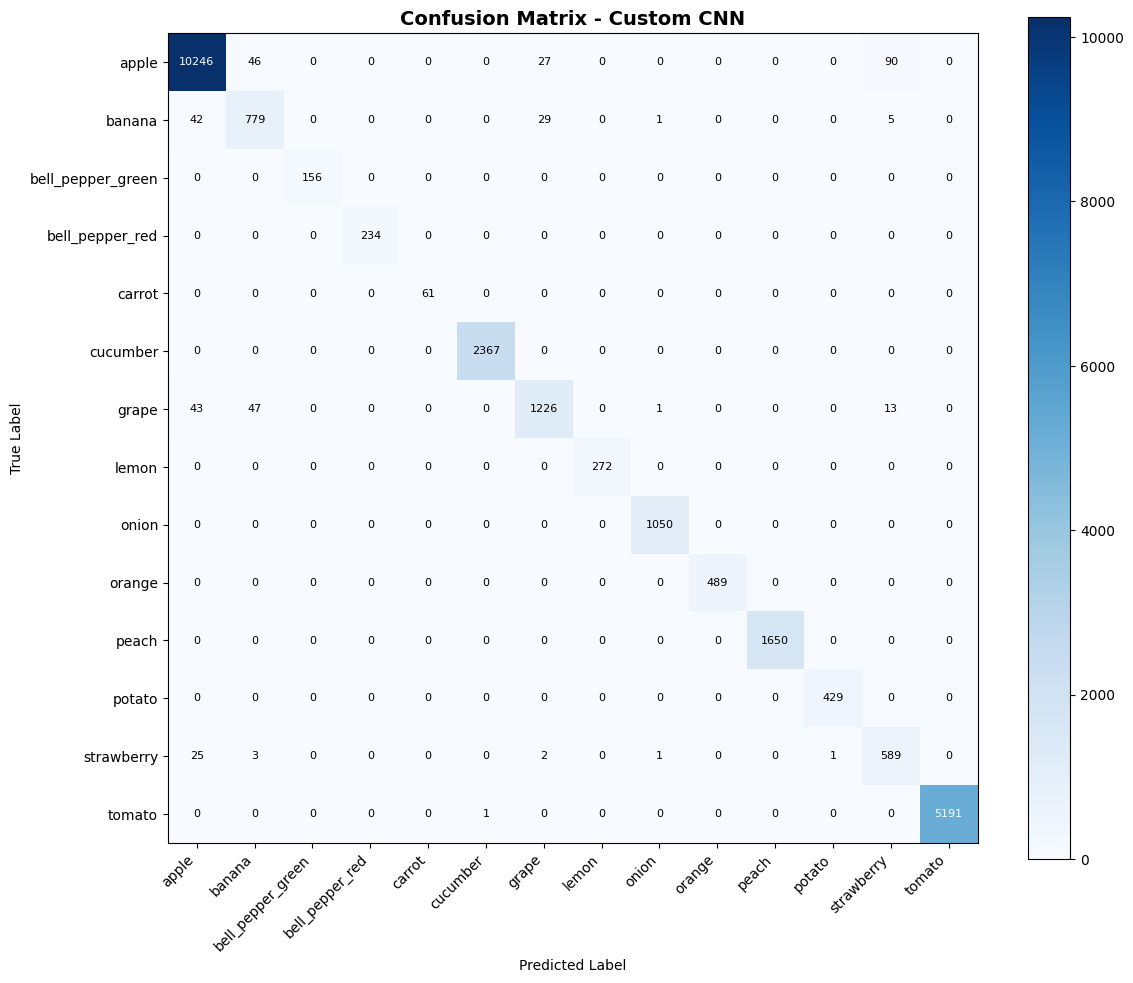


Confusion matrix saved to: /content/custom_cnn_confusion_matrix.png


In [15]:
# ================================================================
# CELL 10: CLASSIFICATION REPORT & CONFUSION MATRIX
# ================================================================
# Detailed per-class metrics and confusion matrix visualization.
# Essential for understanding model performance across categories.
# ================================================================

print("=" * 65)
print("DETAILED CLASSIFICATION METRICS")
print("=" * 65)

# Reset test generator and get predictions
test_generator.reset()

print("\nGenerating predictions on test set...")
predictions = best_model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# -----------------------------
# CLASSIFICATION REPORT
# -----------------------------
print("\n" + "=" * 65)
print("CLASSIFICATION REPORT")
print("=" * 65)

report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels,
    digits=4
)
print(report)

# Store report as dictionary for later use
report_dict = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels,
    output_dict=True
)

# -----------------------------
# CONFUSION MATRIX
# -----------------------------
print("=" * 65)
print("CONFUSION MATRIX")
print("=" * 65)

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Custom CNN', fontsize=14, fontweight='bold')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45, ha='right')
plt.yticks(tick_marks, class_labels)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=8)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/custom_cnn_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved to: /content/custom_cnn_confusion_matrix.png")

In [16]:
# ================================================================
# CELL 11: MEASURE INFERENCE TIME
# ================================================================
# Measures average inference time per image.
# Critical metric for comparing model efficiency.
# ================================================================

import time

print("=" * 65)
print("INFERENCE TIME MEASUREMENT")
print("=" * 65)

# Get a batch of test images
test_generator.reset()
test_batch, _ = next(test_generator)

# Warm-up run (first prediction is often slower)
_ = best_model.predict(test_batch[:1], verbose=0)

# -----------------------------
# SINGLE IMAGE INFERENCE
# -----------------------------
print("\nMeasuring single image inference time...")

single_image = test_batch[:1]
n_runs = 100

times = []
for _ in range(n_runs):
    start = time.perf_counter()
    _ = best_model.predict(single_image, verbose=0)
    end = time.perf_counter()
    times.append((end - start) * 1000)  # Convert to milliseconds

single_avg = np.mean(times)
single_std = np.std(times)

print(f"  Runs:          {n_runs}")
print(f"  Average:       {single_avg:.2f} ms")
print(f"  Std Dev:       {single_std:.2f} ms")

# -----------------------------
# BATCH INFERENCE
# -----------------------------
print("\nMeasuring batch inference time...")

batch_size = 32
batch_images = test_batch[:batch_size]
n_runs = 50

times = []
for _ in range(n_runs):
    start = time.perf_counter()
    _ = best_model.predict(batch_images, verbose=0)
    end = time.perf_counter()
    times.append((end - start) * 1000)

batch_avg = np.mean(times)
batch_std = np.std(times)
per_image_batch = batch_avg / batch_size

print(f"  Batch size:    {batch_size}")
print(f"  Runs:          {n_runs}")
print(f"  Batch avg:     {batch_avg:.2f} ms")
print(f"  Per image:     {per_image_batch:.2f} ms")

# -----------------------------
# STORE RESULTS
# -----------------------------
INFERENCE_TIME_SINGLE = single_avg
INFERENCE_TIME_BATCH = per_image_batch

print(f"\n{'=' * 40}")
print("INFERENCE TIME SUMMARY")
print(f"{'=' * 40}")
print(f"Single image:   {INFERENCE_TIME_SINGLE:.2f} ms")
print(f"Batched (x32):  {INFERENCE_TIME_BATCH:.2f} ms per image")

INFERENCE TIME MEASUREMENT

Measuring single image inference time...
  Runs:          100
  Average:       75.49 ms
  Std Dev:       43.28 ms

Measuring batch inference time...
  Batch size:    32
  Runs:          50
  Batch avg:     68.30 ms
  Per image:     2.13 ms

INFERENCE TIME SUMMARY
Single image:   75.49 ms
Batched (x32):  2.13 ms per image


In [17]:
# ================================================================
# CELL 12: SAVE MODEL & RESULTS SUMMARY
# ================================================================
# Saves the trained model and all metrics to Google Drive.
# Creates a comprehensive summary for comparison with other models.
# ================================================================

import json

print("=" * 65)
print("SAVING MODEL & RESULTS")
print("=" * 65)

# -----------------------------
# SAVE MODEL TO DRIVE
# -----------------------------
DRIVE_MODEL_DIR = "/content/drive/MyDrive/snapshelf_models"
os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)

MODEL_SAVE_PATH = f"{DRIVE_MODEL_DIR}/custom_cnn_model.keras"

print(f"\nSaving model to: {MODEL_SAVE_PATH}")
best_model.save(MODEL_SAVE_PATH)
print("Model saved successfully.")

# Get model file size
model_size_mb = os.path.getsize(MODEL_SAVE_PATH) / (1024 * 1024)

# -----------------------------
# COMPILE RESULTS
# -----------------------------
results = {
    "model_name": "Custom CNN",
    "architecture": {
        "type": "Sequential CNN",
        "conv_blocks": 3,
        "filters": [32, 64, 128],
        "dense_units": 256,
        "dropout": 0.5,
        "input_size": IMG_SIZE,
        "num_classes": NUM_CLASSES
    },
    "training": {
        "epochs_completed": len(history.history['loss']),
        "best_epoch": int(np.argmax(history.history['val_accuracy']) + 1),
        "training_time_seconds": TRAINING_TIME_SECONDS,
        "batch_size": BATCH_SIZE,
        "optimizer": "Adam",
        "initial_learning_rate": 0.001
    },
    "performance": {
        "val_accuracy": float(max(history.history['val_accuracy'])),
        "val_loss": float(history.history['val_loss'][np.argmax(history.history['val_accuracy'])]),
        "test_accuracy": float(test_accuracy),
        "test_loss": float(test_loss)
    },
    "per_class_metrics": {
        class_name: {
            "precision": report_dict[class_name]["precision"],
            "recall": report_dict[class_name]["recall"],
            "f1_score": report_dict[class_name]["f1-score"],
            "support": report_dict[class_name]["support"]
        }
        for class_name in class_labels
    },
    "efficiency": {
        "total_parameters": int(total_params),
        "model_size_mb": round(model_size_mb, 2),
        "inference_time_single_ms": round(INFERENCE_TIME_SINGLE, 2),
        "inference_time_batch_ms": round(INFERENCE_TIME_BATCH, 2)
    }
}

# -----------------------------
# SAVE RESULTS JSON
# -----------------------------
RESULTS_PATH = f"{DRIVE_MODEL_DIR}/custom_cnn_results.json"

print(f"\nSaving results to: {RESULTS_PATH}")
with open(RESULTS_PATH, 'w') as f:
    json.dump(results, f, indent=2)
print("Results saved successfully.")

# -----------------------------
# SAVE PLOTS TO DRIVE
# -----------------------------
print(f"\nSaving plots to Drive...")
shutil.copy('/content/custom_cnn_training_history.png',
            f"{DRIVE_MODEL_DIR}/custom_cnn_training_history.png")
shutil.copy('/content/custom_cnn_confusion_matrix.png',
            f"{DRIVE_MODEL_DIR}/custom_cnn_confusion_matrix.png")
print("Plots saved successfully.")

# -----------------------------
# PRINT FINAL SUMMARY
# -----------------------------
print("\n" + "=" * 65)
print("CUSTOM CNN - FINAL RESULTS SUMMARY")
print("=" * 65)

print(f"""
MODEL ARCHITECTURE
------------------
Type:               Custom Sequential CNN
Conv Blocks:        3 (32 -> 64 -> 128 filters)
Dense Layer:        256 units
Total Parameters:   {total_params:,}
Model Size:         {model_size_mb:.2f} MB

TRAINING
--------
Epochs:             {len(history.history['loss'])}
Best Epoch:         {np.argmax(history.history['val_accuracy']) + 1}
Training Time:      {training_duration}

PERFORMANCE
-----------
Validation Accuracy:  {max(history.history['val_accuracy'])*100:.2f}%
Test Accuracy:        {test_accuracy*100:.2f}%
Test Loss:            {test_loss:.4f}

EFFICIENCY
----------
Inference (single):   {INFERENCE_TIME_SINGLE:.2f} ms
Inference (batch):    {INFERENCE_TIME_BATCH:.2f} ms/image

FILES SAVED
-----------
Model:    {MODEL_SAVE_PATH}
Results:  {RESULTS_PATH}
Plots:    {DRIVE_MODEL_DIR}/custom_cnn_*.png
""")

print("=" * 65)
print("NOTEBOOK 02 COMPLETE")
print("=" * 65)

SAVING MODEL & RESULTS

Saving model to: /content/drive/MyDrive/snapshelf_models/custom_cnn_model.keras
Model saved successfully.

Saving results to: /content/drive/MyDrive/snapshelf_models/custom_cnn_results.json
Results saved successfully.

Saving plots to Drive...
Plots saved successfully.

CUSTOM CNN - FINAL RESULTS SUMMARY

MODEL ARCHITECTURE
------------------
Type:               Custom Sequential CNN
Conv Blocks:        3 (32 -> 64 -> 128 filters)
Dense Layer:        256 units
Total Parameters:   4,816,590
Model Size:         55.18 MB

TRAINING
--------
Epochs:             24
Best Epoch:         23
Training Time:      1:29:15.221800

PERFORMANCE
-----------
Validation Accuracy:  98.60%
Test Accuracy:        98.50%
Test Loss:            0.0457

EFFICIENCY
----------
Inference (single):   75.49 ms
Inference (batch):    2.13 ms/image

FILES SAVED
-----------
Model:    /content/drive/MyDrive/snapshelf_models/custom_cnn_model.keras
Results:  /content/drive/MyDrive/snapshelf_models/cu